# An introduction to decision trees
with python and sklearn - the Terry Crews of machine learning

We are going to be learning from this great blog post from this human:

https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/

In [ ]:
# # Install the appropriate shizz from the world of programming
# !pip install pydotplus
# !conda install -c anaconda graphviz=2.38.0

In [3]:
# Get all your bits loaded
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="white", color_codes=True)

from sklearn import tree, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, zero_one_loss

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

from IPython.display import Image
from printing_trees import show_tree, manual_tree_classifier, manual_tree_regressor

figure_count = 1

## What is a Decision Tree?
A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

## Regression trees
First of all let us look at a really simple regression tree example. We great some sin data with a few random bits thrown in and build trees of different depths to try and predict the data.

In [ ]:
# Create a random dataset
rng = np.random.RandomState(1)
X_reg = np.sort(5 * rng.rand(80, 1), axis=0)
y_reg = np.sin(X_reg).ravel()
y_reg[::5] += 3 * (0.5 - rng.rand(16))

plt.scatter(X_reg, y_reg, c="black")
plt.show()

In [ ]:
# Fit regression models for different depths
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor()
regr_1.fit(X_reg, y_reg)
regr_2.fit(X_reg, y_reg)
regr_3.fit(X_reg, y_reg)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)

You'll see from the results below that increasing the depth causes the tree to eventually (max depth unlimited) creates a decision tree that has a step for every sample. This is obvious overfitting, because our model is fitting to the noise introduced into our sin wave. 

We also have further overfitting as we are getting our score for our decision tree based on data it has already seen.
Change the depths in the cell above and rerun the one below to see how the tree changes based on the depth limit.

In [ ]:
# Plot the results
# plt.figure(2)
plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')# We only take the two corresponding features

plt.subplot(1,3,1)
plt.scatter(X_reg, y_reg, c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree (with depth %d) Score: %s" % (2, str(regr_1.score(X_reg,y_reg))))

plt.subplot(1,3,2)
plt.scatter(X_reg, y_reg, c="darkorange", label="data")
plt.plot(X_test, y_2, color="cornflowerblue", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree (with depth %d) Score: %s" % (5, str(regr_2.score(X_reg,y_reg))))

plt.subplot(1,3,3)
plt.scatter(X_reg, y_reg, c="darkorange", label="data")
plt.plot(X_test, y_3, color="cornflowerblue", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree (with depth %d) Score: %s" % (regr_3.tree_.max_depth, str(regr_3.score(X_reg,y_reg))))

plt.show()
figure_count += 1

## Build your own trees fools
In this section we build our own tree classifier based on interrogating the movie data with Tableau. Below shows an example of how you set this problem. Because we are creating our own tree splitters for each node we don't have to do too much data wrangling. Later when we want to apply proper decision trees to the data we have to make some changes to our movie data (mostly because sklearn doesn't like strings but more on that later...)

For now we are going to take our movie data and try to see how good we are at seperating our data so that we can accurately classify good movies (one's with an imdb score of 7 or higher). Below we write a function for each node. To start with I would suggest just creating a single node and parsing that into the manual_decision_tree function. This function outputs a list the ith element is the data that fell into the ith node and a png of your tree.

When adding more nodes make sure the number of node functions you pass into the manual_tree_classifier is equal a number in the sequence 2^i-1 (i.e. 1, 3, 7, 15...). If you don't do that, the algorithm will probably break or something and I am not culpable for what happens (this is due to how I wrote this algorithm, not a symptom of trees themselves).

Below is an example of how this function works, also note that each node function should return true or false where your input x is the movie data.

['"#F8F8FF"', '"#CCCCFF"', '"#C4C3D0"', '"#92A1CF"', '"#8C92AC"', '"#0000FF"', '"#2A52BE"', '"#002FA7"', '"#003399"', '"#00009C"', '"#120A8F"', '"#00008B"', '"#000080"', '"#191970"', '"#082567"', '"#002366"']


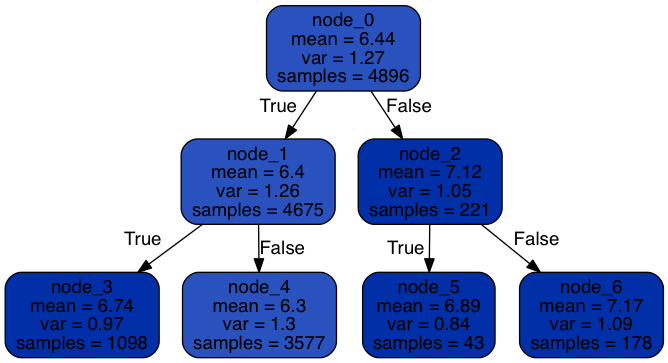

In [4]:
# First let us read in the data and do some simple stuff to it
movie_data = pd.read_csv("movie_2.csv")
movie_data = movie_data.dropna(subset = ["imdb_score"])

# # Change imdb score to category variable
# movie_data["score"] = np.where(list(movie_data["imdb_score"] >= 7), 1, 0)
# movie_data = movie_data.drop("imdb_score", axis = 1)
# Classifier

# get column names of the data so we can reference them in our node splitter functions
# (only if you don't want to use integer values of columns)
# And convert data to numpy array 
col_names = list(movie_data)
movie_data2 = movie_data.values

# Here we define our node splitter functions (have made 3)
def node0(x) :
    return x[col_names.index("color")] == "Color"

def node1(x) :
    return x[col_names.index("director_facebook_likes")] > 200

def node2(x) :
    return x[col_names.index("num_genres")] >= 4

# col number of our outcome we want to predict (don't need to change)
outcome_i = col_names.index("imdb_score")

# This is for the proportion of sames in each node being good. We can set a threshold to change the colour of each node
# red = bad, green = good
# thres = 0.5

# put all our node splitter functions into a list (note the ith element of this list is the splitter for the ith node) 
nodes = [node0, node1, node2]

# node_data, tree_png = manual_tree_classifier(movie_data2, nodes, outcome_i, thres, gini_measure = True)

node_data, tree_png = manual_tree_regressor(movie_data2, nodes, outcome_i)
Image(tree_png)

In [ ]:
# Investigate data outputs
view_data = node_data[0]


### Let's start messing around with simple classification trees
Change the variables below to see how your tree works with the iris data.

The first test output is the precision, recall and f1 score for your tree classifier. Each is explained below:
- Precision: (also called positive predictive value) is the fraction of relevant instances among the retrieved instances
- Recall: (also known as sensitivity) is the fraction of relevant instances that have been retrieved over total relevant instances
- F1 score: a measure of the test's accuracy - a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0

The second outcome is a confusion matrix and finally a plot of the tree

Here we are using the Iris dataset - a standard dataset used in lots of machine learning training. The dataset consists of the petal and sepal length and width of 3 different types of irises.
Could just show this: https://www.kaggle.com/benhamner/python-data-visualizations 

In [ ]:
## Add Pandas of data 

##### DEFINE TREE VARIABLES ####
testing_dataset = load_iris()
max_depth = 4 # default is None, int
min_samples_split = 2 # default = 2, int or float, if float then number is considered as percentage
min_samples_leaf = 1 # default is 1, int or float, if float then number is considered as percentage
criterion = "gini" # default=”gini”, other option is "entropy"
max_features = None 
################################

# Filter out features
# [0,1] for biggest depth with overfitting tree classifier
features_to_use = [0,1]
X = testing_dataset.data[:, features_to_use]
y = testing_dataset.target[:]
feature_names = list(testing_dataset.feature_names[i] for i in features_to_use)
target_names = testing_dataset.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# Create classifier
clf = DecisionTreeClassifier(max_depth=max_depth,
                             min_samples_split = min_samples_split,
                             min_samples_leaf = min_samples_leaf,
                             criterion = criterion,
                             max_features = max_features,
                             random_state=0)

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Average score of tree on testing data: %1.3f \n" %clf.score(X_test, y_test))
print(classification_report(y_test, y_pred, target_names=target_names))
print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns = target_names, index = target_names))
Image(show_tree(clf, feature_names, target_names))

## Pruning example
#### (sklearn doesn't have a specific pruning function, but will demonstrate a very basic idea of pruning below)

This is a simple example to show what might be the best option for tree depth based on iterating through each depth 
of an overfitting tree.

In the example above choose features_to_use as a subset of features (a good one is [0,1] as these features are quite weak in splitting data (you can test this with a 1 depth tree on each of those single features))

From the features given above, we create a tree with no limits (probably overfitting) and get the depth of this classifier. We then iterate from 1 to max depth creating a new classifier for each depth and plot the improvement in score. You'll see a plateau (or decrease at larger max depths) at some point where the increase in depth does not improve score.

For jokes, don't split your data (uncomment the code below, you should see that the score will continue to increase with depth) this shows how it is import to seperate your data into testing, training (and later valildation sets) With over fitting your data and testing on the same data you end up producing an answer for every observation. When you see a truely new sample your model will most likely be crap.

In [ ]:
## To comment in for bare jokes
# X_train = testing_dataset.data[:, features_to_use]
# y_train = testing_dataset.target[:]
# X_test = X_train
# y_test = y_train
##

clf_all = DecisionTreeClassifier().fit(X_train, y_train)
pruning_scores = []

for i in range(1,clf_all.tree_.max_depth) :
    clf = DecisionTreeClassifier(max_depth = i).fit(X_train, y_train)
    pruning_scores.append(clf.score(X_test, y_test))

depth_plot = list(np.arange(1,clf_all.tree_.max_depth))


plt.plot(depth_plot, pruning_scores)
plt.xlabel("Tree depth")
plt.ylabel("Prediction score")
plt.show()

## Now create your own using the Movies dataset and report back in 45 mins

## Regression using adaboost
Regression again! So this is a nice little example of how the outout of a decision tree model can fit to somethings that don't go too well together sin waves and step functions. Below we create a sin wave with a little noise and fit a simple regression tree and an adaboost ensemble to it to see the results.

_**Note**: that we don't do a proper set up of seperating our data cross validation, yada yada yada as this is just a nice visual example to show what adaboost is doing._

In [ ]:
# Our training data
X_reg = np.linspace(0, 6, 100)[:, np.newaxis]
y_reg = np.sin(X_reg).ravel() + np.sin(6 * X_reg).ravel() + rng.normal(0, 0.1, X_reg.shape[0])
plt.scatter(X_reg, y_reg, c="black")
plt.show()

In [ ]:
### fit a simple regression tree and adaboost tree to training data
rng = np.random.RandomState(1)

reg_tree = DecisionTreeRegressor(max_depth=4)

ada_tree = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

# Fit
reg_tree.fit(X_reg, y_reg)
ada_tree.fit(X_reg, y_reg)

# Predict
y_1 = reg_tree.predict(X_reg)
y_2 = ada_tree.predict(X_reg)

# Plot the results
plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(X_reg, y_reg, c="k", label="training samples")
plt.plot(X_reg, y_1, c="g", label="n_estimators=1", linewidth=2)
plt.plot(X_reg, y_2, c="b", label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

## Data Wrangling (yay!)
The best thing about data science - jk no-one likes you data wrangling.

We are going to take our movie data and put it into something more mangagable. In the following steps:
- First of all we read in the movie data (that had some small pre-cleaning done to it, taking out annoying characters and for some reason links where numbers should be)
- Next (for ease) we want to create a single class output (score) so we descritise our imdb score into good (>=7) and bad.
- sklearn has an annoying thing - that R has over it) - it doesn't like string categories, they have to be numerical. So we split our movie data into numerical and categorical. We then convert categorical into numbers using a simple label encoder (0 to n-1) where n is the number of categorical values for each variable. What is good about this encoder is that it categorises NaNs as one of the integers, so we don't have to deal with NaNs for our category features. However, the numerical features have NaNs so we set them to zero using pandas.
- Finally we split our data into training and testing data.

_**Note**: It is worth noting that there are other ways to encode categorical variables, another option is one hot encoder however they might be bad for trees. One hot encoder creates a column for every value in all your category variables and adds a 1 or 0 to state if you observation had that category. Think about how tree splitting works. What will tend to happen is that your trees will favour numerical features over categorical because you will be splitting a very sparse matrix when it comes to categories which won't improve your splitting measure by very much._ 

In [ ]:
movie_data = pd.read_csv("movie_2.csv")
movie_data = movie_data.dropna(subset = ["imdb_score"])

# Change imdb score to category variable
movie_data["score"] = np.where(list(movie_data["imdb_score"] >= 7), "good", "bad")
movie_data = movie_data.drop("imdb_score", axis = 1)

# For later...
# movie_data.rename(columns = {"imdb_score":"score"})

# Some stuff about our data
good = len(movie_data[movie_data["score"] == "good"])
bad = len(movie_data[movie_data["score"] != "good"])
n = len(movie_data)
print("Our movie data has %d observations\nwith %d (%2.1f percent) are good \nand %d (%2.1f) are bad" %(n,good,100*good/n,bad,100*bad/n))

In [ ]:
movie_data_num = movie_data.select_dtypes(exclude=['object']).copy()
movie_data_cats = movie_data.select_dtypes(include=['object']).copy()
print("numerical features: " + str(len(list(movie_data_num))) + "\ncategorical features: " + str(len(list(movie_data_cats))))

In [ ]:
# Fill nas for num as 0
movie_data_num = movie_data_num.fillna(0)

# create encoders for each categorical feature and replace the strings in each feature with a number representation
encoder_dict = {}
for colname in movie_data_cats.columns :
    encoder_dict[colname] = preprocessing.LabelEncoder().fit(list(movie_data_cats[colname]))
    movie_data_cats[colname] = encoder_dict[colname].transform(list(movie_data_cats[colname]))

In [ ]:
# Finally put the numerical and categorical data back together
ml_data = pd.concat([movie_data_cats, movie_data_num], axis = 1)

# Get the data in the right formats for classifiers
X = ml_data.drop("score", axis = 1).as_matrix()
y = ml_data["score"].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state = 0)

## RaRaRa-Random Forest
We are now going to look at ensemble methods and see how well they perform on some real data! #OMG.

This block below applies random forests for different parameter settings. You can create different lists of parameter options (max_depths, max_features and number of trees) checkout the link at the bottom to see what possible values the random forest predictor takes.

The code then creates a random forrest for every possible combination of settings and records the mean score of each predictor using cross validation.

The results are then plotted in a multi-dimensional plot (I think there is a name for this but I can't remember what it is called) each subplot plots the mean score of your predictor, std bands and the test score. Where the subplot x = the varying number of trees and y is the score. Then each subplot varies in the X direction with a new feature option and the Y varies with max_depth. 

Feel free to steal the code above on decision tree classification to test single random forest classifiers. 

There is also some code (if I have time) to view the ROC curve of your predictor.

Feel free to see whatever measures you wish to vary or change from this link:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier


#### SELECT arrays of n_estimators, max_depth and max_features. Note I think max plot for subplotting is 9 by 9
# Also note the more options the longer the it will take
n_estimators = [10,50,100,150,200,250,300]
max_depths = [1, 2, 8]
max_features = ["auto", "sqrt", 0.5]
criterion = "gini"
#####

# iterate over all random forrest tree settings calculating cross validation for each random forrest
# (brute force is often not possible to find true optimum -
# see feature and hyperparameter selection sklearn to do this properly)
results = []
for d in max_depths :
    for f in max_features :
        results.append({"depth":d, "feat":f, "avg_scores":[], "std_lower": [], "std_upper": [], "test_err": []})
        for n in n_estimators :
            clf = RandomForestClassifier(n_estimators=n, criterion=criterion, max_depth=d, n_jobs=1, random_state=None)
            scores = cross_val_score(clf, X_train, y_train)
            results[-1]["avg_scores"].append(scores.mean())
            results[-1]["std_upper"].append(scores.mean() + scores.std())
            results[-1]["std_lower"].append(scores.mean() - scores.std())
            results[-1]["test_err"].append(clf.fit(X_train, y_train).score(X_test, y_test))
            
            

In [ ]:
plt.figure(figsize=(18, 18), dpi= 80, facecolor='w', edgecolor='k')
for i in range(len(results)) :
    plt.subplot(len(max_depths), len(max_features), i+1)
    plt.plot(n_estimators, results[i]["avg_scores"], color="b", linewidth=2)
    plt.plot(n_estimators, results[i]["test_err"], color="black", linewidth=2, linestyle='dashed')
    plt.fill_between(n_estimators, results[i]["std_lower"], results[i]["std_upper"], alpha=0.2, color="b")
    if i % len(max_depths) == 0 :
        plt.ylabel("max_depth = %d" % (results[i]["depth"]))
    if i < len(max_features) :
        plt.title("max_features = %s" % (str(results[i]["feat"])))
    
#     plt.xlabel("no. of trees")
#     plt.ylabel("mean cv error")
#     plt.title("max_depth = %d, max_features = %s" % (results[i]["depth"], str(results[i]["feat"])))

plt.suptitle("x = number of trees, y = mean cross validation error")
plt.show()

## Boosted Trees (adaboost)
Okay now we are going to do the same thing we did with random forrests but now with adaboost.

The code to apply adaboost is in the exact same setup with a small difference. Random forrests are a classifier but adaboost is a boosting technique which we can apply to trees. Therefore we create our tree classifier and then use the boosting algorithm with that tree classifier. Because boosting is a general technique it means you can apply it to any classifier you want - that's pretty gangster.

In [ ]:
#### SELECT arrays of n_estimators, max_depth and max_features. Note I think max plot for subplotting is 9 by 9
# Also note the more options the longer the it will take
n_estimators = [10,50,100,150,200]
max_depths = [1, 2, 8]
learning_rates = [1, 0.5, 0.25]
criterion = "gini"
#####

# iterate over all random forrest tree settings calculating cross validation for each random forrest
# (brute force is often not possible to find true optimum -
# see feature and hyperparameter selection sklearn to do this properly)
results = []
for d in max_depths :
    for l in learning_rates :
        results.append({"depth":d, "learn":l, "avg_scores":[], "std_lower": [], "std_upper": [], "test_err": []})
        for n in n_estimators :
            clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=d, criterion=criterion), 
                                     learning_rate=l, n_estimators=n)
            scores = cross_val_score(clf, X_train, y_train)
            results[-1]["avg_scores"].append(scores.mean())
            results[-1]["std_upper"].append(scores.mean() + scores.std())
            results[-1]["std_lower"].append(scores.mean() - scores.std())
            results[-1]["test_err"].append(clf.fit(X_train, y_train).score(X_test, y_test))

In [ ]:
plt.figure(figsize=(18, 18), dpi= 80, facecolor='w', edgecolor='k')
for i in range(len(results)) :
    plt.subplot(len(max_depths), len(learning_rates), i+1)
    plt.plot(n_estimators, results[i]["avg_scores"], color="b", linewidth=2)
    plt.plot(n_estimators, results[i]["test_err"], color="black", linewidth=2, linestyle='dashed')
    plt.fill_between(n_estimators, results[i]["std_lower"], results[i]["std_upper"], alpha=0.2, color="b")
    if i % len(max_depths) == 0 :
        plt.ylabel("max_depth = %d" % (results[i]["depth"]))
    if i < len(learning_rates) :
        plt.title("learning_rate = %s" % (str(results[i]["learn"])))
    
#     plt.xlabel("no. of trees")
#     plt.ylabel("mean cv error")
#     plt.title("max_depth = %d, max_features = %s" % (results[i]["depth"], str(results[i]["feat"])))

plt.suptitle("x = number of trees, y = mean cross validation error")
plt.show()

In [ ]:
# DONE